In [1]:
import pandas as pd
%matplotlib inline
from datetime import datetime

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
import random
from collections import defaultdict

class Sampler():
    def __init__(self, ped_posx_mean, ped_posx_std, ped_posy_mean, ped_posy_std, ped_vel_mean, ped_vel_std, car_posx_mean, car_posx_std, car_posy_mean, car_posy_std, car_vel_mean, car_vel_std ):
        self.ped_posx_mean, self.ped_posx_std, self.ped_posy_mean, self.ped_posy_std, self.ped_vel_mean, self.ped_vel_std, self.car_posx_mean, self.car_posx_std, self.car_posy_mean, self.car_posy_std, self.car_vel_mean, self.car_vel_std = ped_posx_mean, ped_posx_std, ped_posy_mean, ped_posy_std, ped_vel_mean, ped_vel_std, car_posx_mean, car_posx_std, car_posy_mean, car_posy_std, car_vel_mean, car_vel_std
    
    def random_sample(self):
        self.ped_x = np.random.uniform(self.ped_posx_mean-self.ped_posx_std,self.ped_posx_mean+self.ped_posx_std,1)[0]
        self.ped_y = np.random.normal(self.ped_posy_mean,self.ped_posy_mean,1)[0]
        self.pos_x = 0#np.random.normal(self.car_posx_mean,self.car_posx_std,1)[0]
        self.pos_y = np.random.normal(self.car_posy_mean,self.car_posy_std,1)[0]
        self.vel = np.random.uniform(self.car_vel_mean-self.car_vel_std,self.car_vel_mean-self.car_vel_std,1)[0]
        self.SP = np.random.choice([0],1,[1.0])[0]
        return {'ped_x': self.ped_x, 'ped_y': self.ped_y, 'pos_x': self.pos_x, 'pos_y': self.pos_y, 'vel': self.vel, 'SP': self.SP}

In [3]:
from collections import namedtuple

features = ['ped_x','ped_y','pos_x','pos_y', 'vel']
State = namedtuple('State', features, verbose=True)


class State(tuple):
    'State(ped_x, ped_y, pos_x, pos_y, vel)'

    __slots__ = ()

    _fields = ('ped_x', 'ped_y', 'pos_x', 'pos_y', 'vel')

    def __new__(_cls, ped_x, ped_y, pos_x, pos_y, vel):
        'Create new instance of State(ped_x, ped_y, pos_x, pos_y, vel)'
        return _tuple.__new__(_cls, (ped_x, ped_y, pos_x, pos_y, vel))

    @classmethod
    def _make(cls, iterable, new=tuple.__new__, len=len):
        'Make a new State object from a sequence or iterable'
        result = new(cls, iterable)
        if len(result) != 5:
            raise TypeError('Expected 5 arguments, got %d' % len(result))
        return result

    def __repr__(self):
        'Return a nicely formatted representation string'
        return 'State(ped_x=%r, ped_y=%r, pos_x=%r, pos_y=%r, vel=%r)' % self

    def _asdict(self):
        'Return a new OrderedDict which maps field names to their values'
        return OrderedDict(zip(self._fields, self))

    def _replace(_self, **kwds):
        'Ret

In [4]:
class CarBrakerEnv():
    def __init__(self,sampler):
        self.sampler = sampler
        self.reset_state()
        
    def reset_state(self):
        self.state = sampler.random_sample()
        self.SP = self.state['SP']
        state_val = []
        self.ped_x = self.state['ped_x']
        assert self.ped_x != 75
        assert self.state['vel'] != 5
        self.ped_y = self.state['ped_y']
        self.end_pos_x = 125.0
        for name in features:
            state_val.append(self.state[name])
        
        self.state_tuple = State._make(state_val)
        self.state = self.state_tuple
        self.state_tuple = self.state_tuple._replace(ped_x = -1)
        self.state_tuple = self.state_tuple._replace(ped_y = -1)

        self.possible_actions = [0,1] # 0 for not braking, 1 for braking to the warning
        self.time = 0
        self.warning_signalled = 0
        self.terminated = False
        return
    
    def next_step(self, action):
        self.time+=1
        self.reward = -1
        if(action == 0):
            self.state_tuple = self.state_tuple._replace(pos_x = self.state_tuple.pos_x + self.state_tuple.vel)
        if(self.ped_x > 0 and abs(self.ped_x - self.state_tuple.pos_x)<=20 and self.warning_signalled==0):
            self.state_tuple = self.state_tuple._replace(ped_x = self.ped_x)
            self.state_tuple = self.state_tuple._replace(ped_y = self.ped_y)
            self.warning_signalled = 1
            
        if(action == 0 and self.state_tuple.ped_x > 0 and (self.state_tuple.ped_x<=self.state_tuple.pos_x)):
            self.reward = -1000
            self.terminated = True
        elif(action == 1 and self.state_tuple.ped_x > 0):
            self.reward = 100
            self.terminated = True
        if(self.state_tuple.pos_x >= self.end_pos_x or (self.state_tuple.ped_x > 0 and action==0 and (self.state_tuple.ped_x<=self.state_tuple.pos_x))):
            self.terminated = True
        return (self.state_tuple), self.reward
    
    


In [5]:
sampler = Sampler( ped_posx_mean=75, ped_posx_std=30, ped_posy_mean=1, ped_posy_std=0.01, ped_vel_mean=1, ped_vel_std=0.01, car_posx_mean=0.01, car_posx_std=0.01, car_posy_mean=1, car_posy_std=0.01, car_vel_mean=15, car_vel_std=5 )
env = CarBrakerEnv(sampler)
#     print(reward," PED (" + str(state.ped_x) + " , " + str(state.ped_y) +") "," CAR (" + str(state.pos_x) + " , " + str(state.pos_y) +") ")


In [6]:
lines = []
env.reset_state()
print env.state_tuple
while(env.terminated == False):
    state, reward = env.next_step(0)
    lines.append([state.ped_x,state.ped_y,state.pos_x,state.pos_y, reward])
env.reset_state()
print lines

State(ped_x=-1, ped_y=-1, pos_x=0, pos_y=1.0098755422028012, vel=10.0)
[[-1, -1, 10.0, 1.0098755422028012, -1], [-1, -1, 20.0, 1.0098755422028012, -1], [47.468449707579978, 1.6166595966710746, 30.0, 1.0098755422028012, -1], [47.468449707579978, 1.6166595966710746, 40.0, 1.0098755422028012, -1], [47.468449707579978, 1.6166595966710746, 50.0, 1.0098755422028012, -1000]]


In [7]:
from qlearning import *
from sarsa import *

In [8]:
ql = QLearning(env,eps_cnt=30)
ql.run(env)
print ql.episodes,ql.time_steps

0
10
20
[-1010.    30.    96.    -8.    89.    94.    74.    69.    87.    93.
    92.    94.    94.    95.    95.    93.    90.    96.    90.    92.
    93.    95. -1010.    96.    92.    91.    96.    94.    95.    90.] [  11.   71.    5.  109.   12.    7.   27.   32.   14.    8.    9.    7.
    7.    6.    6.    8.   11.    5.   11.    9.    8.    6.   11.    5.
    9.   10.    5.    7.    6.   11.]


In [ ]:
ql.episodes_values[30]

In [10]:
ql = SARSA(env,eps_cnt=30)
ql.run(env)
print ql.episodes,ql.time_steps

[ 85.  76.  94.  85.  96.  89.  93.  94.  96.  93.  94.  95.  92.  96.  94.
  93.  93.  92.  92.  93.  95.  91.  96.  69.  95.  94.  91.  92.  93.  93.] [ 16.  25.   7.  16.   5.  12.   8.   7.   5.   8.   7.   6.   9.   5.   7.
   8.   8.   9.   9.   8.   6.  10.   5.  32.   6.   7.  10.   9.   8.   8.]


[MoviePy] >>>> Building video movie_exp**3_eps_30.mp4
[MoviePy] Writing video movie_exp**3_eps_30.mp4


 95%|█████████▌| 21/22 [00:02<00:00,  8.82it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: movie_exp**3_eps_30.mp4 



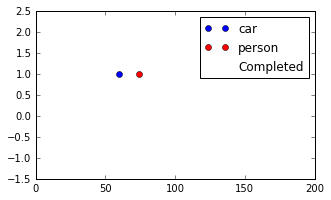

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from moviepy.video.io.bindings import mplfig_to_npimage
import moviepy.editor as mpy

# DRAW A FIGURE WITH MATPLOTLIB

duration = 20

fig_mpl, ax = plt.subplots(1,figsize=(5,3), facecolor='white')
xx = np.linspace(-1,140,200) # the x vector
ax.set_title("Elevation in y=0")
ax.set_ylim(-1.5,2.5)

# ANIMATE WITH MOVIEPY (UPDATE THE CURVE FOR EACH t). MAKE A GIF.
t = 0
episode_id = 30
def make_frame_mpl(m):
    global t,episode_id
    x = []
    y = []
    xobs = []
    yobs = []
    l = float(m)
    if(len(ql.episodes_values[episode_id])>m):
        if(t!=len(ql.episodes_values[episode_id])-1):
            t+=1
            text = 'Velocity'+str(ql.episodes_values[episode_id][int(t)][2])
        else:
            text = 'Completed'
    if(ql.episodes_values[episode_id][int(t)][0]>0):
        xobs.append(int(ql.episodes_values[episode_id][int(t)][0]))
        yobs.append(1)
    x.append(int(ql.episodes_values[episode_id][int(t)][1]))
    y.append(1)
    ax.clear()
    ax.set_ylim(-1.5,2.5)
    ax.set_xlim(0,200)
    ax.plot(x, y, 'bo',label='car')
    ax.plot(xobs, yobs, 'ro',label='person')
    ax.plot([], [], ' ',label=text)
    ax.legend()

    
#     line.set_ydata( )  # <= Update the curve
    return mplfig_to_npimage(fig_mpl) # RGB image of the figure

animation =mpy.VideoClip(make_frame_mpl, duration=len(ql.episodes_values[episode_id])/4.0+3)
# animation.write_gif("sinc_mpl.gif", fps=20)
animation.write_videofile("movie_exp**3_eps_30.mp4",fps=4)